# Decision Tree

---------------------
# Exercises
Using the titanic data, in your classification-exercises repository, create a notebook, model.ipynb where you will do the following:

1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

5. Run through steps 2-4 using a different max_depth value.

6. Which model performs better on your in-sample data?

7. Which model performs best on your out-of-sample data, the validate set?

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz
from graphviz import Graph

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

In [2]:
# Acquire Step
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [3]:
# Set the order of thte data frame based on passenger id 
df = df.set_index("passenger_id")
#Drop unesesary data
df = df.drop(columns=["class", "embarked"])

In [4]:
#check for nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   deck         203 non-null    object 
 8   embark_town  889 non-null    object 
 9   alone        891 non-null    int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 76.6+ KB


In [5]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
deck           688
embark_town      2
alone            0
dtype: int64

In [6]:
# We do not need Deck 
df = df.drop(columns=['deck'])

In [7]:
# Let's fill embark_town with the most common observation
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [8]:
# Check data status on nun values
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embark_town      2
alone            0
dtype: int64

In [9]:
# It looks like there's nothing wildly different about the no age group compared to the population
# So we'll impute using the median age
df.age = df.age.fillna(value=df.age.median())

In [10]:
# drop the rest of nulls 
df.dropna()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone
passenger_id,,,,,,,,,
0,0,3,male,22.0,1,0,7.2500,Southampton,0
1,1,1,female,38.0,1,0,71.2833,Cherbourg,0
2,1,3,female,26.0,0,0,7.9250,Southampton,1
3,1,1,female,35.0,1,0,53.1000,Southampton,0
4,0,3,male,35.0,0,0,8.0500,Southampton,1
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,Southampton,1
887,1,1,female,19.0,0,0,30.0000,Southampton,1
888,0,3,female,28.0,1,2,23.4500,Southampton,0


In [11]:
df.isna().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embark_town    2
alone          0
dtype: int64

In [12]:
# Looking at the distribution of values, it appears that no age subgroup is very close to the population
# If we needed to be more certain, we could perform hypothesis testing
# It looks like there's nothing wildly different about the no age group compared to the population
# So we'll impute using the median age
df.age = df.age.fillna(value=df.age.median())

In [13]:
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [14]:
# split data
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [15]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

# 1. 
What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [16]:
# base line prediction should be 0 
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [17]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = (y_train == 0)

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


# 2.
Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [18]:
# Make the model
tree1 = DecisionTreeClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
tree1 = tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

# 3.
Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [19]:
 print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree1.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [20]:
# confusion matrix - actual on left, predicted on top
pd.DataFrame(confusion_matrix(y_train, y_predictions))

,0,1
0,265,42
1,58,133


In [21]:
# confusion matrix - actual on left, predicted on top
pd.DataFrame(confusion_matrix(y_train, y_predictions))

,0,1
0,265,42
1,58,133


In [22]:
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.820433,0.760000,0.799197,0.790217,0.797255
recall,0.863192,0.696335,0.799197,0.779764,0.799197
f1-score,0.841270,0.726776,0.799197,0.784023,0.797358
support,307.000000,191.000000,0.799197,498.000000,498.000000


# 4.
Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [23]:
# based on confusion matrix and the fact that not-survived is our positive case 
TP = 265
FP = 58
FN = 42
TN = 133
ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7991967871485943
True Positive Rate: 0.8631921824104235
False Positive Rate: 0.3036649214659686
True Negative Rate: 0.6963350785340314
False Negative Rate: 0.13680781758957655
Precision: 0.8204334365325078
Recall: 0.8631921824104235
F1 Score: 0.8412698412698413
Support (0): 307
Support (1): 191


# 5.
Run through steps 2-4 using a different max_depth value.

In [24]:
# Let's 
for i in range(2, 11):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.820433    0.760000  0.799197    0.790217      0.797255
recall       0.863192    0.696335  0.799197    0.779764      0.799197
f1-score     0.841270    0.726776  0.799197    0.784023      0.797358
support    307.000000  191.000000  0.799197  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.829341    0.817073  0.825301    0.823207      0.824636
recall       0.902280    0.701571  0.825301    0.801925      0.825301
f1-score     0.864275    0.754930  0.825301    0.809602      0.822337
support    307.000000  191.000000  0.825301  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.831858    0.842767  0.835341    0.837313      0.836042
recall       0.918567    0.701571  0.835341    0.810069      0.835341
f1-score     

# 6.
Which model performs better on your in-sample data?

#10 has the highest accuaracy

# 7.
Which model performs best on your out-of-sample data, the validate set?

In [25]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 35):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.799197,0.761682,0.037515
1,3,0.825301,0.799065,0.026236
2,4,0.835341,0.794393,0.040949
3,5,0.853414,0.799065,0.054348
4,6,0.865462,0.789720,0.075742
5,7,0.883534,0.780374,0.103160
6,8,0.899598,0.789720,0.109879
7,9,0.917671,0.799065,0.118605
8,10,0.937751,0.785047,0.152704
9,11,0.955823,0.813084,0.142739


In [26]:
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])


,max_depth,train_accuracy,validate_accuracy,difference
1,3,0.825301,0.799065,0.026236
3,5,0.853414,0.799065,0.054348
2,4,0.835341,0.794393,0.040949
4,6,0.865462,0.789720,0.075742
0,2,0.799197,0.761682,0.037515


--------------

# Random Forest
-----------------------
# Exercises
1. Continue working in your model file with titanic data to do the following:

2. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

3. Evaluate your results using the model score, confusion matrix, and classification report.

4. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

5. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

7. After making a few models, which one has the best performance (or closest metrics) on both train and validate?

# 1.
Continue working in your model file with titanic data to do the following:

# 2.
Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [27]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from pydataset import data

In [28]:
# Acquire Step
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [29]:
X_train.shape, X_validate.shape, X_test.shape

((498, 9), (214, 9), (179, 9))

In [30]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [31]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model 
forest1.fit(X_train, y_train)

# Use the model
# Evaluate model's performance on train
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.773481,0.801471,0.781124,0.787476,0.784216
recall,0.912052,0.570681,0.781124,0.741366,0.781124
f1-score,0.837070,0.666667,0.781124,0.751868,0.771715
support,307.000000,191.000000,0.781124,498.000000,498.000000


In [32]:
rf = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=5)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=5)

In [33]:
rf.feature_importances_

array([0.08826559, 0.21605137, 0.04852438, 0.03212837, 0.24533209,
       0.01873577, 0.31065655, 0.01549838, 0.02480751])

In [34]:
y_pred_rf_train = rf.predict(X_train)

# 3.
Evaluate your results using the model score, confusion matrix, and classification report.


In [35]:
rf.score(X_train, y_train)

0.9698795180722891

In [36]:
confusion_matrix(y_train, y_pred_rf_train)

array([[307,   0],
       [ 15, 176]])

In [37]:
print(classification_report(y_train, y_pred_rf_train))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98       307
           1       1.00      0.92      0.96       191

    accuracy                           0.97       498
   macro avg       0.98      0.96      0.97       498
weighted avg       0.97      0.97      0.97       498



# 4.
Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [38]:
confusion_matrix(y_train, y_pred_rf_train)

array([[307,   0],
       [ 15, 176]])

In [39]:
tp = 307
fp = 15
tn = 176
fn = 1
accuracy = accuracy_score(y_train, y_pred_rf_train)
tpr = tp / (tp / fn)
tnr = tn / (fp / tn) 
fpr = 1 - tnr # fp / (fp + tn)
fnr = 1 - tpr # fn / (fn + tp)
precision = precision_score(y_train, y_pred_rf_train)
recall = recall_score(y_train, y_pred_rf_train)
f1 = f1_score(y_train, y_pred_rf_train)
f"accuracy: {accuracy}, tpr: {tpr}, fpr: {fpr}, tnr: {tnr}, fnr: {fnr}, precision: {precision}, recall: {recall}, f1: {f1}"

'accuracy: 0.9698795180722891, tpr: 1.0, fpr: -2064.0666666666666, tnr: 2065.0666666666666, fnr: 0.0, precision: 1.0, recall: 0.9214659685863874, f1: 0.9591280653950953'

In [40]:
print(classification_report(y_train, y_pred_rf_train))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       307
           1       1.00      0.92      0.96       191

    accuracy                           0.97       498
   macro avg       0.98      0.96      0.97       498
weighted avg       0.97      0.97      0.97       498



# 5.
Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [41]:
rf1 = RandomForestClassifier(min_samples_leaf=4, max_depth=6, random_state=5)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=4, random_state=5)

In [42]:
rf1.feature_importances_

array([0.12056514, 0.10557004, 0.04688489, 0.02223547, 0.16989799,
       0.01813543, 0.48230977, 0.01323384, 0.02116744])

In [43]:
y_pred_rf1_train = rf1.predict(X_train)
rf1.score(X_train, y_train)

0.8654618473895582

In [44]:
confusion_matrix(y_train, y_pred_rf1_train)

array([[294,  13],
       [ 54, 137]])

In [45]:
print(classification_report(y_train, y_pred_rf1_train))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       307
           1       0.91      0.72      0.80       191

    accuracy                           0.87       498
   macro avg       0.88      0.84      0.85       498
weighted avg       0.87      0.87      0.86       498



# 6.
What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?


In [46]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.821285,0.771028,0.050257
1,3,3,0.845382,0.785047,0.060335
2,4,4,0.847390,0.794393,0.052997
3,5,5,0.859438,0.799065,0.060372
4,6,6,0.861446,0.799065,0.062380
5,7,7,0.863454,0.789720,0.073734
6,8,8,0.863454,0.789720,0.073734
7,9,9,0.855422,0.794393,0.061029
8,10,10,0.857430,0.785047,0.072383
9,11,11,0.849398,0.785047,0.064351


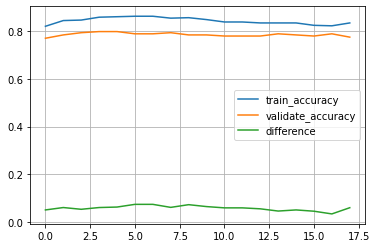

In [47]:
df[['train_accuracy', 'validate_accuracy','difference']].plot()
plt.grid()

In [48]:
# What about a fixed depth and increasing min_samples_leaf

# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []


for i in range(2, 50):
    # Make the model
    depth = 5
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,5,0.861446,0.794393,0.067053
1,3,5,0.859438,0.789720,0.069718
2,4,5,0.857430,0.789720,0.067710
3,5,5,0.859438,0.799065,0.060372
4,6,5,0.859438,0.789720,0.069718
5,7,5,0.851406,0.785047,0.066359
6,8,5,0.855422,0.789720,0.065702
7,9,5,0.845382,0.785047,0.060335
8,10,5,0.847390,0.780374,0.067016
9,11,5,0.839357,0.780374,0.058984


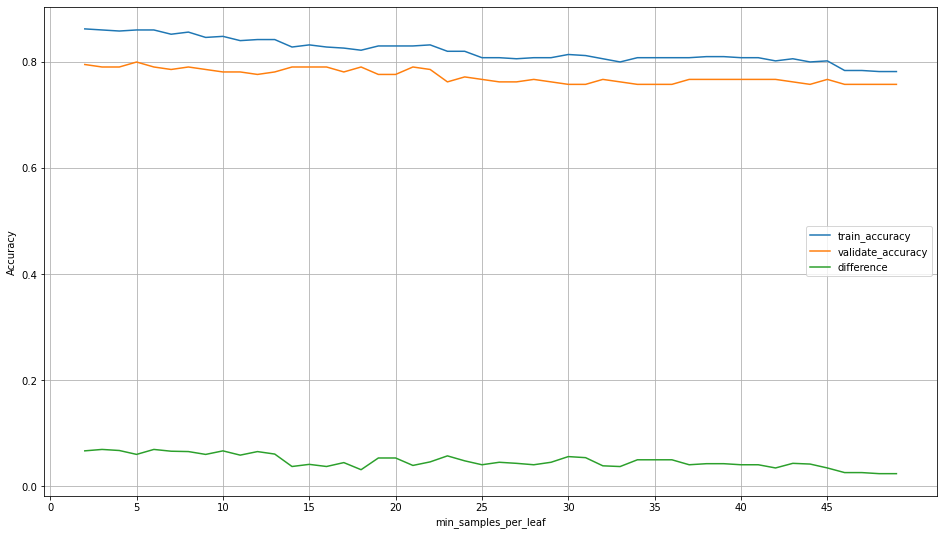

In [49]:
df.set_index('min_samples_per_leaf')[['train_accuracy', 'validate_accuracy', 'difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,50,5))
plt.grid()

--------------------------

# KNN
--------
# Exercises
Continue working in your model file with the titanic dataset.

1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

2. Evaluate your results using the model score, confusion matrix, and classification report.

3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

4. Run through steps 2-4 setting k to 10

5. Run through setps 2-4 setting k to 20

6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

7. Which model performs best on our out-of-sample data from validate?

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. 
Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [51]:
df = acquire.get_titanic_data()

In [52]:
train.shape, validate.shape, test.shape

((498, 10), (214, 10), (179, 10))

In [53]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [54]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [55]:
# get_classification_metrics(knn)
y_pred = knn.predict(X_train)

# 2.
Evaluate your results using the model score, confusion matrix, and classification report.

In [56]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       307
           1       0.73      0.73      0.73       191

    accuracy                           0.79       498
   macro avg       0.78      0.78      0.78       498
weighted avg       0.79      0.79      0.79       498



In [57]:
report = classification_report(y_train, y_pred, output_dict=True)
print("n_neighbour = 5")
pd.DataFrame(report)

n_neighbour = 5


,0,1,accuracy,macro avg,weighted avg
precision,0.831169,0.731579,0.793173,0.781374,0.792973
recall,0.833876,0.727749,0.793173,0.780812,0.793173
f1-score,0.832520,0.729659,0.793173,0.781090,0.793069
support,307.000000,191.000000,0.793173,498.000000,498.000000


In [58]:
confusion_matrix(y_train, y_pred)

array([[256,  51],
       [ 52, 139]])

In [59]:
print('Actual on Left, Predicted on Top')
pd.crosstab(y_train, y_pred)

Actual on Left, Predicted on Top


col_0,0,1
survived,,
0,256,51
1,52,139


# 3.
Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [60]:
# Positive outcome is survival = 1
TN, FP, FN, TP = confusion_matrix(y_train,y_pred).ravel()
ALL = TP + TN + FP + FN

TN, FP, FN, TP 

(256, 51, 52, 139)

In [61]:
accuracy = accuracy_score(y_train, y_pred)
tpr = tp / (tp / fn)
tnr = tn / (fp / tn) 
fpr = 1 - tnr # fp / (fp + tn)
fnr = 1 - tpr # fn / (fn + tp)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
f"accuracy: {accuracy}, tpr: {tpr}, fpr: {fpr}, tnr: {tnr}, \
fnr: {fnr}, precision: {precision}, recall: {recall}, f1: {f1}, \
support:{train["survived"].value_counts()}"


SyntaxError: invalid syntax (<ipython-input-61-066944a63058>, line 11)

In [62]:
# fuction to show ,pde; score given the confusion matrix 
def show_scores(TN, FP, FN, TP):
    
    ALL = TP + TN + FP + FN
    
    accuracy = (TP + TN)/ALL # How often did the model get it right?
    precision = TP/(TP+FP) # What is the quality of a positive prediction made by the model?
    recall = TP/(TP+FN) # How many of the true positives were found?   
    
    true_positive_rate = TP/(TP+FN) # Same as recall, actually
    true_negative_rate = TN/(TN+FP) # How many of the true negatives were found?
    false_positive_rate = FP/(FP+TN) # How often did we miss the negative and accidentally call it positive?
    false_negative_rate = FN/(FN+TP) # How often did we miss the positive and accidentally call it negative?
    
    f1_score = 2*(precision*recall)/(precision+recall) # Harmonic mean, good for imbalanced data sets
    support_pos = TP + FN # Number of actual positives in the sample
    support_neg = FP + TN # Number of actual negatives in the sample
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"True Positive Rate: {true_positive_rate}")
    print(f"True Negative Rate: {true_negative_rate}")
    print(f"False Positive Rate: {false_positive_rate}")
    print(f"False Negative Rate: {false_negative_rate}")
    print(f"F1 Score: {f1_score}")
    print(f"Support (0): {support_pos}")
    print(f"Support (1): {support_neg}")

In [63]:
show_scores(TN, FP, FN, TP)

Accuracy: 0.7931726907630522
Precision: 0.7315789473684211
Recall: 0.7277486910994765
True Positive Rate: 0.7277486910994765
True Negative Rate: 0.8338762214983714
False Positive Rate: 0.16612377850162866
False Negative Rate: 0.27225130890052357
F1 Score: 0.7296587926509187
Support (0): 191
Support (1): 307


# 4. 
Run through steps 2-4 setting k to 10

In [64]:
knn2 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn2.fit(X_train, y_train)
# get_classification_metrics(knn)
y_pred2 = knn2.predict(X_train)

report = classification_report(y_train, y_pred2, output_dict=True)
print("n_neighbour = 10")
pd.DataFrame(report)

n_neighbour = 10


,0,1,accuracy,macro avg,weighted avg
precision,0.743935,0.755906,0.746988,0.749920,0.748526
recall,0.899023,0.502618,0.746988,0.700820,0.746988
f1-score,0.814159,0.603774,0.746988,0.708966,0.733469
support,307.000000,191.000000,0.746988,498.000000,498.000000


In [65]:
# confusion_matrix
print('Actual on Left, Predicted on Top')
pd.crosstab(y_train, y_pred2)

Actual on Left, Predicted on Top


col_0,0,1
survived,,
0,276,31
1,95,96


# 5. 
Run through setps 2-4 setting k to 20

In [66]:
knn3 = KNeighborsClassifier(n_neighbors=20, weights='uniform')
knn3.fit(X_train, y_train)
# get_classification_metrics(knn)
y_pred3 = knn3.predict(X_train)

report = classification_report(y_train, y_pred3, output_dict=True)
print("n_neighbour = 10")
pd.DataFrame(report)

n_neighbour = 10


,0,1,accuracy,macro avg,weighted avg
precision,0.723118,0.698413,0.716867,0.710765,0.713643
recall,0.876221,0.460733,0.716867,0.668477,0.716867
f1-score,0.792342,0.555205,0.716867,0.673773,0.701392
support,307.000000,191.000000,0.716867,498.000000,498.000000


In [67]:
# confusion_matrix
print('Actual on Left, Predicted on Top')
pd.crosstab(y_train, y_pred3)

Actual on Left, Predicted on Top


col_0,0,1
survived,,
0,269,38
1,103,88


# 6.
What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?
- It seems that the less amount of neighbors the better

# 7.
Which model performs best on our out-of-sample data from validate?

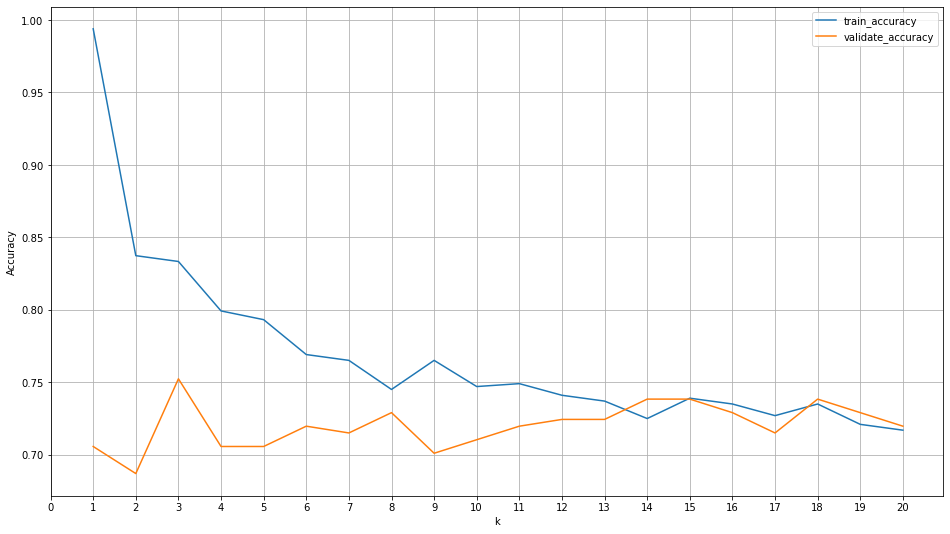

In [68]:
metrics = []

# loop through different values of k
for k in range(1, 21):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

# make a dataframe
results = pd.DataFrame(metrics)

# plot the data
results.set_index('k').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

-------------------

# Logistic Regression
--------
# Exercises

In these exercises, we'll continue working with the titanic dataset and building logistic regression models. Throughout this exercise, be sure you are training, evaluation, and comparing models on the train and validate datasets. The test dataset should only be used for your final model.

For all of the models you create, choose a threshold that optimizes for accuracy.

Do your work for these exercises in either a notebook or a python script named model within your classification-exercises repository. Add, commit, and push your work.

1. Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

2. Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

3. Try out other combinations of features and models.

4. Use you best 3 models to predict and evaluate on your validate sample.

5. Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

# 1.
Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [70]:
train.head(2)

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
583,0,1,36.0,0,0,40.125,1,1,0,0
165,1,3,9.0,0,2,20.525,0,1,0,1


In [71]:
baseline_accuracy = (train.survived == 0).mean()
round(baseline_accuracy, 2)

0.62

In [72]:
# Create the logistic regression
logit = LogisticRegression(random_state=123)

# specify the features we're using
features = ["age", "pclass", "fare"]

# Fit a model using only these specified features
# logit.fit(X_train[["age", "pclass", "fare"]], y_train)
logit.fit(X_train[features], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred = logit.predict(X_train[features])

print("Baseline is", round(baseline_accuracy, 2))
print("Logistic Regression using age, pclass, and fare features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using age, pclass, and fare features
Accuracy of Logistic Regression classifier on training set: 0.70


# 2.
Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

In [73]:
# Create the logistic regression
logit1 = LogisticRegression(random_state=123)

# specify the features we're using
features = ["age", "pclass", "fare", "sex_male"]

# Fit a model using only these specified features
logit1.fit(X_train[features], y_train)

y_pred = logit1.predict(X_train[features])

print("Logistic Regression using age, pclass, fare, and gender features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train[features], y_train)))

Logistic Regression using age, pclass, fare, and gender features
Accuracy of Logistic Regression classifier on training set: 0.81


# 3. 
Try out other combinations of features and models.

In [74]:
logr1 = LogisticRegression(penalty="l2", max_iter=500, solver="lbfgs", random_state=5, C=0.5)
logr1.fit(X_train, y_train)
logr1.score(X_train, y_train)
y_pred_l_train = logr1.predict(X_train)
print(classification_report(y_train, y_pred_l_train))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       307
           1       0.78      0.72      0.75       191

    accuracy                           0.82       498
   macro avg       0.81      0.80      0.80       498
weighted avg       0.81      0.82      0.81       498



In [75]:
logr2 = LogisticRegression(penalty="l2", max_iter=500, solver="sag", random_state=5, C=0.25)
logr2.fit(X_train, y_train)
logr2.score(X_train, y_train)
y_pred_2_train = logr2.predict(X_train)
print(classification_report(y_train, y_pred_2_train))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79       307
           1       0.78      0.26      0.39       191

    accuracy                           0.69       498
   macro avg       0.73      0.61      0.59       498
weighted avg       0.72      0.69      0.64       498



In [76]:
logr3 = LogisticRegression(penalty="l1", max_iter=500, solver="liblinear", random_state=5, C=0.25)
logr3.fit(X_train, y_train)
logr3.score(X_train, y_train)
y_pred_3_train = logr3.predict(X_train)
print(classification_report(y_train, y_pred_3_train))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       307
           1       0.78      0.70      0.73       191

    accuracy                           0.81       498
   macro avg       0.80      0.79      0.79       498
weighted avg       0.81      0.81      0.80       498



In [77]:
logr4 = LogisticRegression(random_state=123, C=0.0001)
logr4.fit(X_train, y_train)

y_pred_4_train = logr4.predict(X_train)
accuracy = logr4.score(X_train, y_train)

y_pred_4_train = logr1.predict(X_train)
print(classification_report(y_train, y_pred_4_train))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       307
           1       0.78      0.72      0.75       191

    accuracy                           0.82       498
   macro avg       0.81      0.80      0.80       498
weighted avg       0.81      0.82      0.81       498



# 4.
Use you best 3 models to predict and evaluate on your validate sample.

In [78]:
y_pred_l = logr1.predict(X_validate)
print(classification_report(y_validate, y_pred_l))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       132
           1       0.75      0.65      0.69        82

    accuracy                           0.78       214
   macro avg       0.77      0.75      0.76       214
weighted avg       0.78      0.78      0.78       214



In [79]:
y_pred_3 = logr3.predict(X_validate)
print(classification_report(y_validate, y_pred_3))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       132
           1       0.71      0.66      0.68        82

    accuracy                           0.77       214
   macro avg       0.75      0.75      0.75       214
weighted avg       0.76      0.77      0.76       214



In [80]:
y_pred_4 = logr4.predict(X_validate)
print(classification_report(y_validate, y_pred_4))

              precision    recall  f1-score   support

           0       0.66      0.98      0.79       132
           1       0.83      0.18      0.30        82

    accuracy                           0.67       214
   macro avg       0.75      0.58      0.54       214
weighted avg       0.73      0.67      0.60       214




# 5.
Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [81]:
y_test_1 = logr1.predict(X_test)
print(classification_report(y_test, y_test_1))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       110
           1       0.77      0.71      0.74        69

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

